In [156]:
import pandas as pd
import numpy as np
import pickle
from collections import Counter, defaultdict

In [157]:
import sys
import os
def add_sys_path(p):
    p = os.path.abspath(p)
    if p not in sys.path:
        sys.path.append(p)

add_sys_path('..')

In [158]:
import evaluate

In [159]:
def evaluate_mine(hypotheses, texts, gt_table):
    gts = defaultdict(list)
    for r, row in gt_table.iterrows():
        gts[row.one_text].append(row.parents_list)
    aps = pd.Series([evaluate.compute_ap(gts[w], hyps, k=10) for w, hyps in zip(texts, hypotheses)])
    return aps, gts

In [160]:
with open('cache/wiki_test_0_1000.pkl', 'rb') as f:
    docs_test = pickle.load(f)

In [161]:
len(docs_test)

762

In [162]:
docs_test[:3]

['Абдоминопластика  (от лат. abdomen «живот») — объёмное оперативное вмешательство, осуществляемое с целью восстановления эстетических пропорций живота. Абдоминопластика направлена на иссечение избытков кожи и жировых отложений, образовавшихся после родов или в силу особенностей строения организма. Как правило, большая часть пациентов — женщины после родов.\n',
 'Сорбенты (от лат. sorbens — поглощающий) — твердые тела или жидкости, избирательно поглощающие (сорбирующие) из окружающей среды газы, пары или растворённые вещества. В зависимости от характера сорбции различают абсорбенты — тела, образующие с поглощённым веществом твёрдый или жидкий раствор, адсорбенты — тела, поглощающие (сгущающие) вещество на своей (обычно сильно развитой) поверхности, и химические поглотители, которые связывают поглощаемое вещество, вступая с ним в химическое взаимодействие. Отдельную группу составляют ионообменные сорбенты (иониты), поглощающие из растворов ионы одного типа с выделением в раствор эквивал

In [163]:
public_test_nouns = pd.read_csv('../data/public_test/nouns_public.tsv', header=None, encoding='utf-8')
public_test_nouns.columns = ['noun']

In [164]:
public_test_nouns['definition'] = docs_test

In [165]:
pd.options.display.max_colwidth = 500

In [166]:
public_test_nouns.sample(3)

,noun,definition
478,ПНЕВМОКОКК,"Пневмококк[2] (лат. Streptococcus pneumoniae) — вид бактерий из рода стрептококков (Streptococcus), неподвижный ланцетовидный диплококк длиной 0,5—1,25 мкм. В русскоязычной литературе известен также как диплококк Вейксельбаума и диплококк Френкеля.\n"
350,МЕМУАРЫ,"Мемуарная литература, мемуары (от фр. mémoires — воспоминания) — записки современников, повествующие о событиях, в которых автор записок принимал участие или которые известны ему от очевидцев, и о людях, с которыми автор был знаком. Важная особенность мемуаров заключается в претензии на достоверность воссоздаваемого прошлого и, соответственно, на документальный характер текста, хотя в действительности не все мемуары являются правдивыми и точными.\n"
287,КОШАРА,Кошара:\n


**Бейзлайн**: находим все синсеты, слова из которых входят в данный текст после первого тире. 

In [167]:
l, r = public_test_nouns.definition[293].split('—', maxsplit=1)
print(l)
print(r)

Криптон 
  химический элемент с атомным номером 36[4]. Принадлежит к 18-й группе периодической таблицы химических элементов (по устаревшей короткой форме периодической системы принадлежит к главной подгруппе VIII группы, или к группе VIIIA), находится в четвёртом периоде таблицы. Атомная масса элемента 83,798(2) а. е. м.[1].  Обозначается символом Kr (от лат. Krypton). Простое вещество криптон — инертный одноатомный газ без цвета, вкуса и запаха.



In [168]:
from pymorphy2 import MorphAnalyzer
from functools import lru_cache

morph = MorphAnalyzer()

@lru_cache(maxsize=10000)
def word2lemma(word):
    parses = morph.parse(word)
    for p in parses:
        if p.normal_form:
            return p.normal_form
    return word

In [169]:
import razdel

In [172]:
def prepare_definition(text, first_sentence=False):
    if first_sentence:
        text = list(razdel.sentenize(text))[0].text
    if '—' not in text:
        return ''
    l, r = text.split('—', maxsplit=1)
    prepared = ' '.join([word2lemma(w.text) for w in razdel.tokenize(r)]).upper()
    return prepared

In [173]:
prepare_definition(public_test_nouns.definition[293], first_sentence=False)

'ХИМИЧЕСКИЙ ЭЛЕМЕНТ С АТОМНЫЙ НОМЕР 36 [ 4 ] . ПРИНАДЛЕЖАТЬ К 18-ТЬ ГРУППА ПЕРИОДИЧЕСКИЙ ТАБЛИЦА ХИМИЧЕСКИЙ ЭЛЕМЕНТ ( ПО УСТАРЕВШИЙ КОРОТКИЙ ФОРМА ПЕРИОДИЧЕСКИЙ СИСТЕМА ПРИНАДЛЕЖАТЬ К ГЛАВНЫЙ ПОДГРУППА VIII ГРУППА , ИЛИ К ГРУППА VIIIA ) , НАХОДИТЬСЯ В ЧЕТЫРЕ ПЕРИОД ТАБЛИЦА . АТОМНЫЙ МАССА ЭЛЕМЕНТ 83,798 ( 2 ) А . Е . МЕТР . [ 1 ] . ОБОЗНАЧАТЬСЯ СИМВОЛ KR ( ОТ ЛАТА . KRYPTON ) . ПРОСТОЙ ВЕЩЕСТВО КРИПТОН — ИНЕРТНЫЙ ОДНОАТОМНЫЙ ГАЗ БЕЗ ЦВЕТ , ВКУС И ЗАПАХ .'

In [175]:
import xmltodict

In [176]:
with open('../data/ruwordnet/synsets.N.xml', 'r', encoding='utf-8') as f:
    synsets_n_raw = xmltodict.parse(f.read(), process_namespaces=True)

id2synset = {v['@id']: v for v in synsets_n_raw['synsets']['synset']}
print(len(id2synset))
    
word2sense = defaultdict(set)
for synset_id, synset in id2synset.items():
    senses = synset['sense']
    if not isinstance(senses, list):
        senses = [senses]
    texts = {sense['#text'] for sense in senses}
    texts.add(synset['@ruthes_name'])
    for text in texts:
        word2sense[text].add(synset_id)
print(len(word2sense))

29296
86549


In [177]:
ttest_dev = pd.read_pickle('ttest_dev.pkl')
ttest_dev['definition'] = pd.read_pickle('cache/wiki_ttest_dev_0_1000.pkl')

In [178]:
ttest_test1 = pd.read_pickle('ttest_test1.pkl')
ttest_test1['definition'] = pd.read_pickle('cache/wiki_ttest_test1_0_1000.pkl')

In [179]:
synset_id = ttest_dev.sample(1).iloc[0].SYNSET_ID
print(synset_id)
df = ttest_dev[ttest_dev.SYNSET_ID==synset_id]
df

140470-N


,SYNSET_ID,TEXT,PARENTS,DEFINITION,parents_list,synset_hash,one_text,definition
4096,140470-N,ПЕРЕСТРОЙКА,"126898-N,106549-N",название исторического периода в СССР с 1986 по 1991 гг.,"[126898-N, 106549-N]",0.815291,ПЕРЕСТРОЙКА,"Перестройка — масштабные изменения в государственной идеологии, экономике, внутренней и внешней политике СССР, начавшиеся во второй половине 1980-х годов.\n"
4097,140470-N,ПЕРЕСТРОЙКА,"137303-N,106785-N",название исторического периода в СССР с 1986 по 1991 гг.,"[137303-N, 106785-N]",0.815291,ПЕРЕСТРОЙКА,"Перестройка — масштабные изменения в государственной идеологии, экономике, внутренней и внешней политике СССР, начавшиеся во второй половине 1980-х годов.\n"
4098,140470-N,ПЕРЕСТРОЙКА,"7936-N,106629-N,106785-N",название исторического периода в СССР с 1986 по 1991 гг.,"[7936-N, 106629-N, 106785-N]",0.815291,ПЕРЕСТРОЙКА,"Перестройка — масштабные изменения в государственной идеологии, экономике, внутренней и внешней политике СССР, начавшиеся во второй половине 1980-х годов.\n"


In [180]:
for pars in df.parents_list:
    print(' | '.join([id2synset[p]['@ruthes_name'] for p in pars]))

СОБЫТИЕ ИСТОРИИ | СОБЫТИЕ, ФАКТ
ПЕРЕСТРОИТЬ ПОРЯДОК, СИСТЕМУ | ПРЕОБРАЗОВАТЬ, ПЕРЕДЕЛАТЬ
РЕФОРМА | ИЗМЕНИТЬСЯ, ИЗМЕНЕНИЕ | ПРЕОБРАЗОВАТЬ, ПЕРЕДЕЛАТЬ


In [181]:
defin = prepare_definition(df.definition.iloc[0], first_sentence=True)
print(defin)

МАСШТАБНЫЙ ИЗМЕНЕНИЕ В ГОСУДАРСТВЕННЫЙ ИДЕОЛОГИЯ , ЭКОНОМИКА , ВНУТРЕННИЙ И ВНЕШНИЙ ПОЛИТИКА СССР , НАЧАТЬСЯ В ДВА ПОЛОВИНА 1980-ХА ГОД .


In [182]:
from tqdm.auto import trange, tqdm

In [183]:
def extract_hypotheses(dataframe, first_sentence=True):
    origins = []
    words = []
    senses = []
    targets = []
    features = []

    for synset_id in tqdm(set(dataframe.SYNSET_ID)):
        df = dataframe[dataframe.SYNSET_ID==synset_id]
        defin = prepare_definition(df.definition.iloc[0], first_sentence=first_sentence)
        if 'parents_list' in df.columns:
            true_values = {v for pars in df.parents_list for v in pars}
        else:
            true_values = set()
        for w, wsenses in word2sense.items():
            if w in defin:        
                for sense in wsenses:
                    origins.append(df.one_text.iloc[0])
                    words.append(w)
                    senses.append(sense)
                    targets.append(sense in true_values)
                    features.append({'position': defin.find(w), 'len': len(w), 'n_senses': len(wsenses)})
    features = pd.DataFrame.from_records(features)
    targets = pd.Series(targets)
    return origins, words, senses, features, targets

In [184]:
origins, words, senses, X_dev, y_dev = extract_hypotheses(ttest_dev, first_sentence=False)
print(X_dev.shape)
print(y_dev.mean(), y_dev.sum())


(9663, 3)
0.012418503570319777 120


In [163]:
from sklearn.linear_model import LogisticRegression

In [164]:
lr = LogisticRegression()
lr.fit(X_dev, y_dev);
print(lr.coef_)

[[-0.00867818  0.13265812 -0.42108646]]


In [165]:
origins, words, senses, X_test1, y_test1 = extract_hypotheses(ttest_test1, first_sentence=False)
print(X_test1.shape)
print(y_test1.mean(), y_test1.sum())


(10858, 3)
0.010130779149014552 110


In [166]:
scores = lr.predict_proba(X_test1)[:, 1]

In [167]:
from sklearn.metrics import roc_auc_score

In [168]:
print(roc_auc_score(y_test1, scores)*2-1)

0.7124369861623303


In [169]:
scores_df = pd.DataFrame({'origin': origins, 'sense': senses, 'score': scores})

In [170]:
hypos_ranked_df = scores_df.groupby('origin').apply(lambda x: x.sort_values('score', ascending=False).sense.head(10).tolist())
hypos_ranked_df

origin
АБСОЛЮТНОСТЬ            [114364-N, 6783-N, 145566-N, 511-N, 119354-N, 4226-N, 146591-N, 106488-N, 107442-N, 121686-N]
АВИАДИСПЕТЧЕР               [129838-N, 7003-N, 198-N, 3698-N, 2550-N, 6577-N, 106529-N, 106530-N, 126350-N, 145684-N]
АЗАРТ                [120522-N, 106968-N, 106651-N, 4131-N, 140086-N, 5641-N, 110249-N, 106660-N, 126367-N, 120999-N]
АЙМАРА           [105048-N, 101422-N, 109776-N, 105137-N, 104707-N, 107581-N, 103506-N, 100070-N, 126820-N, 148389-N]
АКСАЙ                    [7472-N, 8765-N, 110872-N, 9019-N, 114364-N, 3264-N, 107257-N, 100022-N, 138562-N, 108669-N]
                                                                 ...                                                 
ШАШКА                                                                                    [114364-N, 107257-N, 3264-N]
ЩАВЕЛЬ                    [6862-N, 134162-N, 4339-N, 127599-N, 761-N, 121049-N, 107445-N, 4339-N, 109156-N, 148327-N]
ЭЛЕКТРОЛИЗ                  [6052-N, 111680-N, 10

In [171]:
small_hypos = hypos_ranked_df.values.tolist()
texts = hypos_ranked_df.index.tolist()

Что ж, на бейзлайне мы получили качество 14.67%[31%|47%] (против тех 25%, что у меня на лидерборде). 

Если брать целый текст, то будет 14.2%[35%|40%]

Есть куда расти, конечно. Но уже очень впечатляет!

In [172]:
aps, _ = evaluate_mine(small_hypos, texts, ttest_test1)
print(aps.mean())
print((aps>0).mean())
print(aps[aps>0].mean())
aps.describe()

0.14201018117684783
0.3515151515151515
0.4039944809341361


count    165.000000
mean       0.142010
std        0.267568
min        0.000000
25%        0.000000
50%        0.000000
75%        0.166667
max        1.000000
dtype: float64

А что будет, если мы научимся ранжировать гипотезы идеально? Какая максимальная капасити самой матчилки-по-вхождению-строки?

Что оказывается:
* Скор 33% для первого предложения / 40% для абзаца  - это меньше, чем у лидера лидерборда, но дохуя больше, чем я выдаю сейчас
* При этом хоть один верный родитель извлекается в 38% (из первого предложения) / 44% (из первого абзаца) случаев.
* Если хоть один верный родитель извлёкся, то 90% родителей извлеклись!

In [173]:
scores_df = pd.DataFrame({'origin': origins, 'sense': senses, 'score': y_test1})
hypos_ranked_df = scores_df.groupby('origin').apply(lambda x: x.sort_values('score', ascending=False).sense.head(10).tolist())
small_hypos = hypos_ranked_df.values.tolist()
texts = hypos_ranked_df.index.tolist()

aps, _ = evaluate_mine(small_hypos, texts, ttest_test1)
print(aps.mean())
print((aps>0).mean())
print(aps[aps>0].mean())
aps.describe()

0.39898989898989895
0.44242424242424244
0.9018264840182649


count    165.000000
mean       0.398990
std        0.468412
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
dtype: float64

# Анализ полноты вытаскивателя вики

In [6]:
import download_wiki
from importlib import reload
reload(download_wiki);

In [25]:
import evaluate
import json
import random
import my_knn

In [10]:
n_ds = evaluate.read_dataset('../data/training_data/training_nouns.tsv',  lambda x: json.loads(x))

In [98]:
public_test_nouns = pd.read_csv('../data/public_test/nouns_public.tsv', header=None)
public_test_nouns.columns = ['text']

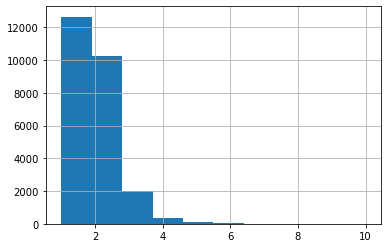

In [94]:
pd.Series(list(n_ds.keys())).apply(lambda x: len(x.split())).hist();

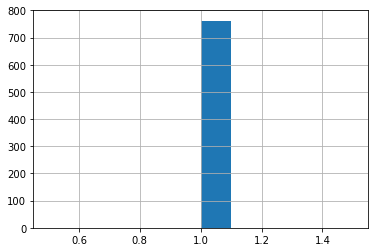

In [99]:
public_test_nouns.text.apply(lambda x: len(x.split())).hist();

In [27]:
syns_storage, rel_storage, rel_df = my_knn.prepare_storages(
    synsets_filename='../data/ruwordnet/synsets.N.xml',
    relations_filename='../data/ruwordnet/synset_relations.N.xml',
    forbidden_words=set(),
)

number of texts: 86549
forbidden senses are 0
numer of ids 29296 long list is 119273



28118
555
5
37249


In [11]:
nouns = list(n_ds.keys())

In [125]:
w = random.choice(nouns)

In [146]:
import urllib.parse

domain = 'ru.m.wikipedia.org'
query = urllib.parse.quote_plus(w)
url = 'http://{}/w/index.php?search={}'.format(domain, query)
print(url)

http://ru.m.wikipedia.org/w/index.php?search=%D0%91%D0%9B%D0%90%D0%93%D0%9E%D0%A3%D0%A1%D0%A2%D0%A0%D0%9E%D0%99%D0%A1%D0%A2%D0%92%D0%9E


прохладность
выдалбливание
подкатка
чуванка
нетерпение
харканье (есть плеванье, перенаправлено с харкание)
смиренность (есть смирение)

In [155]:
while True:
    w = random.choice(nouns)
    if len(w.split()) > 1:
        continue
    print(w)
    for component in n_ds[w]:
        print([syns_storage.get_synset_name(ss) for ss in component])
    dfn = download_wiki.get_definition(w)
    if dfn == 'no_p':
        query = urllib.parse.quote_plus(w)
        print('http://{}/w/index.php?search={}'.format(domain, query))
        break

ОБРЫВАНИЕ
['РАЗЪЕДИНИТЬ, ПРЕРВАТЬ СОЕДИНЕНИЕ', 'ДЕЛИТЬ, РАЗДЕЛЯТЬ НА ЧАСТИ', 'ОТДЕЛИТЬ ЧАСТЬ ОТ ЦЕЛОГО', 'УДАЛИТЬ, ОТДАЛИТЬ НА РАССТОЯНИЕ']
['ПРЕКРАТИТЬ, ПОЛОЖИТЬ КОНЕЦ', 'ПРИНУДИТЬ, ЗАСТАВИТЬ']
ОБРЫВАНИЕ
http://ru.m.wikipedia.org/w/index.php?search=%D0%9E%D0%91%D0%A0%D0%AB%D0%92%D0%90%D0%9D%D0%98%D0%95


C:\Users\ddale\YandexDisk\code\NLP\taxonomy-enrichment\experiments\download_wiki.py:36: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 36 of the file C:\Users\ddale\YandexDisk\code\NLP\taxonomy-enrichment\experiments\download_wiki.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(t)


In [143]:
dfn = download_wiki.get_definition(w)
print(dfn)

РОСТОВЧАНИН
no_p


Проблемы:
* (3) слишком абстрактное слово ("отключение", "нарезание", "прессовка") - поискать в других источниках
* (3) составное понятие ( "пункт приема", "похищение автомобиля", "революционные перемены") - оставить только голову
* (2) частичный мэтч ("настоятель церкви" vs "настоятель", "онкологический диспансер") - попробовать первый результат
* (1) слишком редкое слово (лесопиломатериал, сельхозинститут, центризбирком) - попробовать сначала найти расшифровку слова
* (1) необычная форма слова ("половчанка") - попробовать поискать другие формы
* (1) имя собственное вместо нарицательного ("телеэкран")

Идеи: 
* если идёт пара "существительное прилагательное" или "существительное существительного", гипероним - это определяемое существительное

впрочем, на паблик и прайват тесте все понятия - однословные. 

может, мне мои данные так же пофильтровать?

http://ru.m.wikipedia.org/w/index.php?search=%D0%91%D0%9B%D0%90%D0%93%D0%9E%D0%A3%D0%A1%D0%A2%D0%A0%D0%9E%D0%99%D0%A1%D0%A2%D0%92%D0%9E


# Joint cache

In [186]:
import pandas as pd

In [193]:
df = pd.read_csv('../data/training_data/training_nouns.tsv', sep='\t', encoding='utf-8', header=None)
texts = df[0]

In [194]:
texts

0                            CALL-ЦЕНТР
1                                   GPB
2                        HR ДЕПАРТАМЕНТ
3                              HR ОТДЕЛ
4                           LCD МОНИТОР
                      ...              
32442              ЯЩИК ДЛЯ ГОЛОСОВАНИЯ
32443    ЯЩИК ИЗ ГОФРИРОВАННОГО КАРТОНА
32444                   ЯЩИК ИЗ КАРТОНА
32445                    ЯЩИК КАРТОННЫЙ
32446                              ЯЩУР
Name: 0, Length: 32447, dtype: object